# 03. Image Preprocessing

In this notebook we will set up both reference and consumer images for neural network processing.  We will start by addressing the reference images, better known to our model as our training set.  Since we are training our model with categorical data, we need to create folders for each medication (our categories).  Then we move on to converting each image into arrays that the neural network can interpret.  We will the notebook by converting the consumer-grade (testing set) images as well and saving it down for when our model is ready to generate predictions.

***NOTE:*** *Due to various iterations of our model in the next notebook, we have made some changes throughout this notebook.*
- *Anything changes made that starts with **UPDATE_1** is due to our computer running out of memory when running the CNN.*
- *Anything with **UPDATE_2** is in reference to our model accuracy results being 0.00%.*

---
## Table of Contents

- [01. Import Libraries](#01.-Import-Libraries)
- [02. Read In, Clean, Visualize](#02.-Read-In,-Clean,-Visualize)
- [03. Folder Creation](#03.-Folder-Creation)
- [04. Populate Folders](#04.-Populate-Folders)
- [05. Image Conversion](#05.-Image-Conversion)
    - [05.01. Training Images](#05.01.-Training-Images)
    - [05.02. Test Images](#05.02.-Test-Images)
- [06. Saving Data](#06.-Saving-Data)
- [07. Observations](#07.-Observations)

---
### 01. Import Libraries

In this notebook we will be leveraging the following libraries:
- `numpy`: for dealing with arrays
- `pandas`: for dealing with the csv file as a dataframe
- `matplotlib`: generate preview of images inline
- `os`: used in conjunction with shutil in order to relocate downloads
- `shutil`: used in conjunction with os in order to relocate downloads
- `cv2`: OpenCV - computer vision library to use for images
- `tqdm`: progress bar to gauge length of time needed for functions to run
- `random`: to shuffle the order of our data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import cv2
from tqdm import tqdm
import random

%matplotlib inline

---
### 02. Read In, Clean, Visualize

For the training data, we are going to create folders based on the reference images.  Therefore, we need to pull in the proper reference directory and leverage its contents for what we need. We will create a new dataframe that consists of the medication's `name`, `rxnavImageFileName`, and `nlmImageFileName` to use in the creation of the training set.

In [2]:
ref_data = pd.read_csv('../data/directory_reference_images.csv')

ref_lookup = ref_data[['name', 'rxnavImageFileName', 'nlmImageFileName']]
ref_lookup.head()

,name,rxnavImageFileName,nlmImageFileName
0,Loperamide Hydrochloride 2 MG Oral Capsule,00093-0311-01_RXNAVIMAGE10_26211358.jpg,00093-0311-01_NLMIMAGE10_6315B1FD.jpg
1,Minocycline 50 MG Oral Capsule,00093-3165-01_RXNAVIMAGE10_36231B28.jpg,00093-3165-01_NLMIMAGE10_19270CA8.jpg
2,Nortriptyline 10 MG Oral Capsule,00093-0810-01_RXNAVIMAGE10_24231228.jpg,00093-0810-01_NLMIMAGE10_34271A58.jpg
3,Nortriptyline 25 MG Oral Capsule,00093-0811-01_RXNAVIMAGE10_20231018.jpg,00093-0811-01_NLMIMAGE10_15270A98.jpg
4,Nortriptyline 50 MG Oral Capsule,00093-0812-01_RXNAVIMAGE10_2D2316D8.jpg,00093-0812-01_NLMIMAGE10_DD0E6EE3.jpg


Here we will be doing some quick cleaning, as to make sure that there aren't any issues down the line.  Furthermore, we want to get a feel for the makeup of the data.

In [3]:
ref_lookup.groupby(ref_lookup['name']).count().shape[0]

2111

In [4]:
ref_lookup.shape[0]

4392

There are a total of 4,392 images across 2,112 unique medications used for reference.

In [5]:
# Checking for na
ref_lookup.isna().sum()

name                  60
rxnavImageFileName     0
nlmImageFileName       0
dtype: int64

In [6]:
ref_lookup[ref_lookup['name'].isna()].head()

,name,rxnavImageFileName,nlmImageFileName
17,NaN,00093-4356-01_RXNAVIMAGE10_0E210728.jpg,00093-4356-01_NLMIMAGE10_0E210728.jpg
398,NaN,00525-1102-90_RXNAVIMAGE10_A839D46E.jpg,00525-1102-90_NLMIMAGE10_A839D46E.jpg
505,NaN,00093-0852-53_RXNAVIMAGE10_2C241600.jpg,00093-0852-53_NLMIMAGE10_2C241600.jpg
544,NaN,53489-0469-01_RXNAVIMAGE10_E92374FB.jpg,53489-0469-01_NLMIMAGE10_E92374FB.jpg
565,NaN,00172-5361-60_RXNAVIMAGE10_CA23650B.jpg,00172-5361-60_NLMIMAGE10_CA23650B.jpg


In [7]:
ref_lookup.shape

(4392, 3)

As there are a total of 60 rows out of 4,392 with `na` values (in this case, all 60 do not have a medication name), we will drop the rows, which account for 1.36% of the total.

In [8]:
ref_lookup.dropna(inplace = True)
ref_lookup.reset_index(inplace = True)

C:\Users\Fausto\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
ref_lookup.shape

(4332, 4)

In [10]:
# Count of unique medications
len(ref_lookup['name'].unique())

2111

It looks like we dropped 60 images of medications for our data set.  As such, we are now aiming to generate 2,111 folders in total in which to store 4,332 images.  Next we will take a look at which images are that of capsules and which are for tablets.

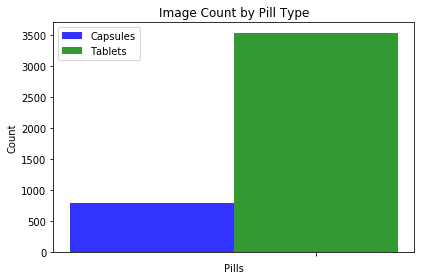

There are a total of 794 capsule images and 3534 tablet images that we can use for reference.


In [34]:
# Data to plot
n_groups = 1
cap_count = ref_lookup['name'].str.contains('Capsule').sum()
tab_count = ref_lookup['name'].str.contains('Tab').sum()

# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index,
                 cap_count,
                 bar_width,
                 alpha=opacity,
                 color='b',
                 label='Capsules')

rects2 = plt.bar(index + bar_width,
                 tab_count,
                 bar_width,
                 alpha=opacity,
                 color='g',
                 label='Tablets')

plt.xlabel('Pills')
plt.ylabel('Count')
plt.title('Image Count by Pill Type')
plt.xticks(index + bar_width, ())
plt.legend()

plt.tight_layout()
plt.show();
fig.savefig('../images/pill_breakdown.png')

# Print results
print (f"There are a total of {cap_count} capsule images and {tab_count} tablet images that we can use for reference.")

***UPDATE_2:*** *Due to, after various iterations of training, our model having a 0.00% accuracy score, we will be modifying the training data to contain only those medications with over 8 images.  Once we establish a working model, we will iterate to include more medications.*

In [12]:
pill_count_df = ref_lookup.groupby(ref_lookup['name'], as_index=False).count()
pill_count_df.head()

,name,index,rxnavImageFileName,nlmImageFileName
0,12 HR Acetazolamide 500 MG Extended Release Or...,3,3,3
1,12 HR Acetazolamide 500 MG Extended Release Or...,1,1,1
2,12 HR Albuterol 4 MG Extended Release Oral Tablet,1,1,1
3,12 HR Amoxicillin 1000 MG / Clavulanate 62.5 M...,2,2,2
4,12 HR Bupropion Hydrochloride 100 MG Extended ...,1,1,1


In [13]:
pill_filter = pill_count_df[pill_count_df['nlmImageFileName'] > 8].head(10)
pill_filter.reset_index(inplace = True)
pill_filter.drop(columns = 'level_0', inplace = True)
pill_filter.drop(columns = 'index', inplace = True)
pill_filter

,name,rxnavImageFileName,nlmImageFileName
0,Lisinopril 20 MG Oral Tablet,9,9
1,Lisinopril 5 MG Oral Tablet,9,9
2,Simvastatin 5 MG Oral Tablet,9,9
3,pantoprazole 40 MG Delayed Release Oral Tablet,10,10


---
### 03. Folder Creation

Since we want to train our neural network to identify the appropriate pills, we first need to sort all of the reference images that were downloaded into folders with their appropriate medication names.  The code below will use the `ref_lookup` generated above to gather the names of each unique medication and create a  folder with the respective name.

In [14]:
folder_path_to = '../images/training_set'
folder_names = list(pill_filter['name'].unique())
count = 0

for names in folder_names:
    try:
        os.mkdir(os.path.join(folder_path_to, str(names)))
        count += 1
    except:
        pass
    
print(f'Created a total of {count} folders.')

Created a total of 0 folders.


After running the above code, we ended up generating 1,743 out of the expected 2,111 total unique pills.  The placement of `try / except` in the code was intentional, as, given that we are currently limited in time, we cannot address a total of 367 issues, which accounts for 17% of the total unique medications.  Given more time, we would be able to go though some of these issues.  A quick glance lets us know that there are some naming issues with the medication, as shown below, where 2 folders have the same name, however, one of them also has an alternative name for the same medication:

![Folders](../images/folders.jpg)

This implies that there are actually $less$ medications than the previously observed 2,111.  This merrits more investigation when more time arises.

***UPDATE_2:*** *Due to the need to change certain inputs to our model, we have created a total of 4 folders, as the previously generated 1,743 did not function properly.*  In rerunning the code, if the folders have already been created, the code will not create another folder.

Here, we will create folders for the test / validation data.

In [15]:
folder_path_to = '../images/consumer/validation_set'
folder_names = list(pill_filter['name'].unique())
count = 0

for names in folder_names:
    try:
        os.mkdir(os.path.join(folder_path_to, str(names)))
        count += 1
    except:
        pass
    
print(f'Created a total of {count} folders.')

Created a total of 0 folders.


---
### 04. Populate Folders

Our next step is to populate each generated folder with the appropriate reference pill images.  We will leverage `ref_lookup` again in order to do this.

For the `path_from` below, the reference images have multiple folders for each size of a pill image.  There are a total of 5 folders (120, 300, 600, 800, 1024), where each medication has an image in 120x120, 300x300, etc. - each image in their respective size folder.  We chose not to use the 1024 images to train due to the nature of a high quality photo - there are a lot of details and we do not want to risk the model looking for exact specifications, especially since the consumer images vary in size, resolution and details.  On the other hand, we do not want to use the 120 images due to dilution of the image (we guess that the model would be good at identifying shapes this way, but not identifying the actual medication).  As a result, we selected the middle (600) to go through.

***UPDATE:*** *Due to memory issues when running our CNN in the next notebook, we need to reduce the amount of training data created.  As such, we will work with the images located in the `nlmImageFileName` column.  The code for moving `rxvnavImageFileName` is still avaliable below.  Furthermore, we have changed the `path_from` variable to reflect the size folder as 300, as opposed to the originally selected 600.*

***UPDATE_2:*** *Since our model reflected a 0.00% accuracy, we will change the folder to access down to 120 and only account for 4 medications total.*

In [16]:
path_from = '../images/reference/120/'
path_to = '../images/training_set/'

In the following codes, we will iterate through `rxvnavImageFileName` and `nlmImageFileName` columns in `ref_lookup` data and look for the files listed.  When the file is found, it will be moved to the appropriate folder.  The aforementioned columns are different image types for the same medication, which effectively doubles the amount of training data we have to work with.

In [17]:
# how many files are in the source folder
len(os.listdir(path_from))

8785

We can expect to look through a total of 8,785 files for our images to copy to their respective folders.

In [18]:
# # Sorting images by 'rxnavImageFileName'
# for name in tqdm(ref_lookup['rxnavImageFileName']): # tqdm => progress bar to gauge time it takes to run
#     folder_loc = ref_lookup.loc[ref_lookup['rxnavImageFileName'] == name, 'name'].iloc[0] +'/'
#     final_destination = f'{path_to}{folder_loc}'
   
#     try:
#         for file in os.listdir(path_from): 
#             if file.startswith(name):
#                 shutil.copy(path_from + file, final_destination)
#     except:
#         pass

In [19]:
# Sorting images by 'nlmImageFileName'
for name in tqdm(ref_lookup['nlmImageFileName']):
    folder_loc = ref_lookup.loc[ref_lookup['nlmImageFileName'] == name, 'name'].iloc[0] +'/'
    final_destination = f'{path_to}{folder_loc}'
   
    try:
        for file in os.listdir(path_from):
            if file.startswith(name):
                shutil.copy(path_from + file, final_destination)
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████| 4332/4332 [02:49<00:00, 25.62it/s]


After running through the code, and given that the previous iteration missed 1,469 out of 8,784 images to move, we can expect to see that there are still a handful of images that were not copied over to the appropriate folders.  This is most likely due to possible errors not being addressed (intentional, as `try / except` has been placed in the code).  Similiar to above, we are pressed for time and, therefore, will ignore the errors for the time being.  Given more time, we will address each issues appropriately.  For the sake of arguement, we will proceed assuming that 4,332 (the number on the progres bar) images were copied over. 

---
### 05. Image Conversion

In this section we will convert all of the images into array, and ultimately combine them, so that our model can process it.

#### 05.01. Training Images

In [20]:
# Instantiate where we will be pulling the images from
data_directory = '../images/training_set/'

# Instantiating a list of folder names to iterate through
categories = os.listdir(data_directory)

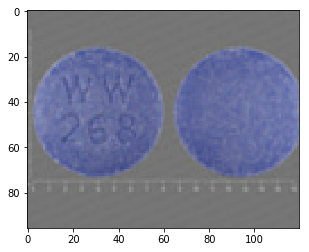

In [21]:
for category in categories:
    # Instantiate path to each medication folder created
    path = os.path.join(data_directory,category)
    # Iterate over each image per folder
    for img in os.listdir(path):
        # Convert each image into an array
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
        new_array = cv2.resize(img_array, (120, 96))
        plt.imshow(new_array)  # display image
        
        break  # we want to look at what everything will look like, so the 1st image will suffice
    break

(**Note**: *matplotlib displays color images using the RGB format vs OpenCV's BGR format.  The above pill image is displayed with the incorrect color format, but we only wanted to check that the function worked properly for what follows.*)

In [22]:
# Take a look at the shape of the array for the above image
new_array.shape

(96, 120, 3)

The image array will not be printed out, as it is (as shown above) a long array.  So now that we're familiar with the image, and what we can expect the array to look like, we will build out the function to include all images in each medication folder and well as combine them to feed the model.  We can expect to convert a total of 7,315 images (8,784 - 1,469).

In [23]:
def create_training_data(file_path, n = -1):
    
    categories = os.listdir(file_path)
    
    if n != -1:
        categories = categories[:n]

    training_data = []
    
    for category in tqdm(categories):
        path = os.path.join(file_path,category + '/')
        # get the classification
        classification_num = categories.index(category)

        for img in os.listdir(path):
            try:
                # convert to array
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
                # resizing array to be more uniform
                new_array = cv2.resize(img_array, (120, 96))
                # add to training data
                training_data.append([new_array, classification_num])
            except:  
                pass
            
    return training_data

In [24]:
training_data = create_training_data('../images/training_set/')
print(f'Total files converted: {len(training_data)}')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 148.52it/s]


Total files converted: 37


Out of 4,332 images that were expected to be converted, only 3,643 images were - a 16% reduction.  As seems to be the recurring theme in this notebook `try / except` has been placed, due to the lack of time needed to properly address issues with the notebook.

***UPDATE:*** *Due to necessary changes in the pre-processing stage, we reduced the amount of images to convert down to 37.*

In [25]:
# Checking the first 5 images in our results
for sample in training_data[:5]:
    # Check the categories for each image
    print(sample[1])

0
0
0
0
0


We will randomize the order of our `training_data`, since we populated it sequencially (i.e. the first 5 images are classified under the same folder, since they all came from folder `0`).

In [26]:
random.shuffle(training_data)

for sample in training_data[:5]:
    print(sample[1])

3
1
0
1
0


#### 05.02. Test Images

In the above, we successfully converted the training images into arrays.  In the following section, we will convert the test images into arrays.  The images are located in the `./images/consumer/` folder.

In [27]:
print(len(os.listdir('../images/consumer/')))

59416


There are a total of 59,416 images that we will convert into arrays.

In [28]:
def create_testing_data(file_path, n = -1):
    
    images = os.listdir(file_path)
    
    if n != -1:
        images = images[:n]

    testing_data = []
    
    for img in tqdm(images):
        try:
            img_array = cv2.imread(os.path.join(file_path,img) ,cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (125, 96))
            classification_num = categories.index(category)
            testing_data.append([new_array, classification_num])
        except:  
            pass
            
    return testing_data

To ensure that we are properly testing out our model in the next notebook, we will only convert the first 100 images.  After we can validate the model, we will increase the test data size.

***UPDATE_2:*** *Since we reduced the training size of our model, we will increase the testing / validation dataset from 100 to 1,000 - since we are training with significantly less medications this time around.*

In [29]:
testing_data = create_testing_data('../images/consumer/', 1_000)
print(f'Total files converted: {len(testing_data)}')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:14<00:00,  4.28it/s]


Total files converted: 1000


Seeing as that 1,000 images have been converted into arrays, we can move on to the next step.

---
### 06. Saving Data

In this final section, we will save down our `training_data` as serialized data using the `pickle` library.  This makes it more efficient (space-wise) as well as easier to access and reconstruct in the next notebook.

First, we must set up our X and y variables:

In [30]:
# Instantiate our features
X = []

# Instantiate our labels
y = []

# Assign data to variables
for features, labels in training_data:
    X.append(features)
    y.append(labels)

# Convert to array
X = np.array(X)
y = np.array(y)
z = np.array(testing_data)

Now that our data is stored as arrays, we will save them down in the `/data` folder.

In [31]:
# Save down our variables
np.save('../data/X_train', X, allow_pickle = True)
np.save('../data/y_train', y, allow_pickle = True)
np.save('../data/z_test', z, allow_pickle = True)

---
### 07. Observations

The pre-processing steps taken in this notebook significantly reduced the amount of images available to setup from 8,784 down to 5,572 - a 36.5% reduction.  Most of the issues stem from three primary factors:

- The naming convention used for each medication in the directory
- Moving images to their appropriate folders / classification
- Converting images into arrays


Furthermore, we encountered issues with our model that needs further addressing, given the existence of **UPDATE_n**.

- ***UPDATE_1:*** *Well, clearly we have reduced the initial 36.5% reduction even furthur due to OOM (Out of Memory) errors that we continually received in the CNN notebook.*

- ***UPDATE_2*** *We further reduced the total amount of training due to our 0.00% accuracy score.*

When we circle back to this notebook, with more time, we will address these issues - which would go a long way towards providing a full, robust data set for training.  Overall, we anticipate our modeling being able to identify certain medications with a high level of accuracy and other medications with a very low level of accuracy, given that it lacks the appropriate identifying details.

With the pre-processing complete for the training data, we will move on to the next notebook in order to train our model with the data generated.

---